In [2]:
!pip install pandasql
!pip install statsmodels
!pip install xgboost
!pip install missingno

#veri işleme için gerekli kütüphaneler
import numpy as np
import pandas as pd
import pandasql as psql

#veri görselleştirme için gerekli kütüphaneler
import seaborn as sbn
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno

#makine öğrenimi için gerekli kütüphaneler
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error
from sklearn.ensemble import IsolationForest,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet,ElasticNetCV
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("testFeatures.csv")

test = test.drop(["id"],axis=1)
test["ürün fiyatı"] = "test!"

veri = pd.concat([train,test],axis=0)

In [4]:
veri.shape

(273024, 8)

# Keşifsel Veri Analizi Aşaması

In [5]:
def verikontrol(veri):
    if veri.isnull().sum().sum()>0:
        print(veri.isnull().sum())
        msno.matrix(veri)
    else:
        print("Boş veri bulunmadı.")

verikontrol(train)
verikontrol(test)
verikontrol(veri)

Boş veri bulunmadı.
Boş veri bulunmadı.
Boş veri bulunmadı.


In [6]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273024 entries, 0 to 45503
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tarih              273024 non-null  object
 1   ürün               273024 non-null  object
 2   ürün besin değeri  273024 non-null  int64 
 3   ürün kategorisi    273024 non-null  object
 4   ürün fiyatı        273024 non-null  object
 5   ürün üretim yeri   273024 non-null  object
 6   market             273024 non-null  object
 7   şehir              273024 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.7+ MB


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227520 entries, 0 to 227519
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tarih              227520 non-null  object 
 1   ürün               227520 non-null  object 
 2   ürün besin değeri  227520 non-null  int64  
 3   ürün kategorisi    227520 non-null  object 
 4   ürün fiyatı        227520 non-null  float64
 5   ürün üretim yeri   227520 non-null  object 
 6   market             227520 non-null  object 
 7   şehir              227520 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 13.9+ MB


In [8]:
kategorik = veri.select_dtypes(include=["object"])

def kate():
    for i in kategorik.columns:
        if veri[i].unique().shape[0]<10:
            print("sütun= {0}:".format(i),"\nsütun içeriği= ",
                  veri[i].unique())
            print("----------------------------------------------")
            print(veri[i].value_counts())
            print("----------------------------------------------")

kate()

sütun= ürün kategorisi: 
sütun içeriği=  ['et' 'sebze ve bakliyat' 'tahıl ve ürünleri'
 'süt ürünleri ve kahvaltılık' 'meyve' 'kuruyemiş']
----------------------------------------------
sebze ve bakliyat              100224
meyve                           62208
süt ürünleri ve kahvaltılık     41472
tahıl ve ürünleri               41472
kuruyemiş                       17280
et                              10368
Name: ürün kategorisi, dtype: int64
----------------------------------------------
sütun= ürün üretim yeri: 
sütun içeriği=  ['Yurt içi' 'Yurt dışı']
----------------------------------------------
Yurt içi     136512
Yurt dışı    136512
Name: ürün üretim yeri, dtype: int64
----------------------------------------------
sütun= market: 
sütun içeriği=  ['M' 'C' 'B']
----------------------------------------------
C    91008
M    91008
B    91008
Name: market, dtype: int64
----------------------------------------------
sütun= şehir: 
sütun içeriği=  ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H']


In [9]:
veri.describe()

,ürün besin değeri
count,273024.000000
mean,143.113924
std,133.218822
min,8.000000
25%,41.000000
50%,83.000000
75%,250.000000
max,402.000000


In [10]:
train.describe()

,ürün besin değeri,ürün fiyatı
count,227520.000000,227520.000000
mean,143.113924,16.348622
std,133.218871,13.260935
min,8.000000,0.730000
25%,41.000000,7.330000
50%,83.000000,12.600000
75%,250.000000,20.900000
max,402.000000,141.330000


# Veri Önişleme ve F.E Aşaması

F.E Feature Engineering/Özellik Mühendisliği

In [11]:
kuru = psql.sqldf("select * from veri where ürün like '%kuru'")
kuru["ürün durum"] = 1

taze = psql.sqldf("select * from veri where ürün like '%taze'")
taze["ürün durum"] = 0

hiçbiri = psql.sqldf("select * from veri where ürün not like '%taze' and ürün not like '%kuru'")
hiçbiri["ürün durum"] = -1

veri = pd.concat([kuru,taze,hiçbiri],axis=0)
veri["ürün üretim yeri"]=veri["ürün üretim yeri"].astype("category")
veri["ürün üretim yeri"]=veri["ürün üretim yeri"].cat.codes

veri[['C', 'M']]=pd.get_dummies(veri["market"],drop_first=True)

veri[['B', 'C', 'D', 'E', 'F', 'G', 'H']]=pd.get_dummies(veri["şehir"],drop_first=True)

veri[['kuruyemiş', 'meyve', 'sebze ve bakliyat','süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri']]=pd.get_dummies(veri["ürün kategorisi"],drop_first=True)



In [12]:
veri['tarih'] = pd.to_datetime(train['tarih'])
veri["yıl"] = veri["tarih"].dt.year
veri["ay"] = veri["tarih"].dt.month

In [13]:
test = veri[veri["ürün fiyatı"]=="test!"]
train = veri[veri["ürün fiyatı"]!="test!"]

test = test.drop("ürün fiyatı",axis=1)

In [14]:
test.columns

Index(['tarih', 'ürün', 'ürün besin değeri', 'ürün kategorisi',
       'ürün üretim yeri', 'market', 'şehir', 'ürün durum', 'C', 'M', 'B', 'D',
       'E', 'F', 'G', 'H', 'kuruyemiş', 'meyve', 'sebze ve bakliyat',
       'süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri', 'yıl', 'ay'],
      dtype='object')

In [15]:
train.columns

Index(['tarih', 'ürün', 'ürün besin değeri', 'ürün kategorisi', 'ürün fiyatı',
       'ürün üretim yeri', 'market', 'şehir', 'ürün durum', 'C', 'M', 'B', 'D',
       'E', 'F', 'G', 'H', 'kuruyemiş', 'meyve', 'sebze ve bakliyat',
       'süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri', 'yıl', 'ay'],
      dtype='object')

In [16]:
train["ürün fiyatı"]=train["ürün fiyatı"].astype("float")
train

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir,ürün durum,C,...,F,G,H,kuruyemiş,meyve,sebze ve bakliyat,süt ürünleri ve kahvaltılık,tahıl ve ürünleri,yıl,ay
0,2016-01-01,Bakla-kuru,354,sebze ve bakliyat,7.02,1,M,A,1,0,...,0,0,0,0,0,1,0,0,2016.0,1.0
1,2016-01-01,Barbunya-kuru,346,sebze ve bakliyat,5.97,1,M,A,1,0,...,0,0,0,0,0,1,0,0,2016.0,1.0
2,2016-01-01,Fasulye-kuru,333,sebze ve bakliyat,9.17,1,M,A,1,0,...,0,0,0,0,0,1,0,0,2016.0,1.0
3,2016-01-01,Mercimek-kuru,351,sebze ve bakliyat,5.10,1,M,A,1,0,...,0,0,0,0,0,1,0,0,2016.0,1.0
4,2016-01-01,Bakla-kuru,354,sebze ve bakliyat,7.17,0,M,A,1,0,...,0,0,0,0,0,1,0,0,2016.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207355,2020-07-01,fındık,110,kuruyemiş,51.19,0,B,H,-1,0,...,0,0,1,1,0,0,0,0,2020.0,7.0
207356,2020-07-01,fıstık,115,kuruyemiş,55.14,0,B,H,-1,0,...,0,0,1,1,0,0,0,0,2020.0,7.0
207357,2020-07-01,kaju,100,kuruyemiş,58.60,0,B,H,-1,0,...,0,0,1,1,0,0,0,0,2020.0,7.0
207358,2020-07-01,badem,110,kuruyemiş,51.83,0,B,H,-1,0,...,0,0,1,1,0,0,0,0,2020.0,7.0


## Grafik ile Veri Analizi Aşaması

In [17]:
train=train.reset_index().drop("index",axis=1)

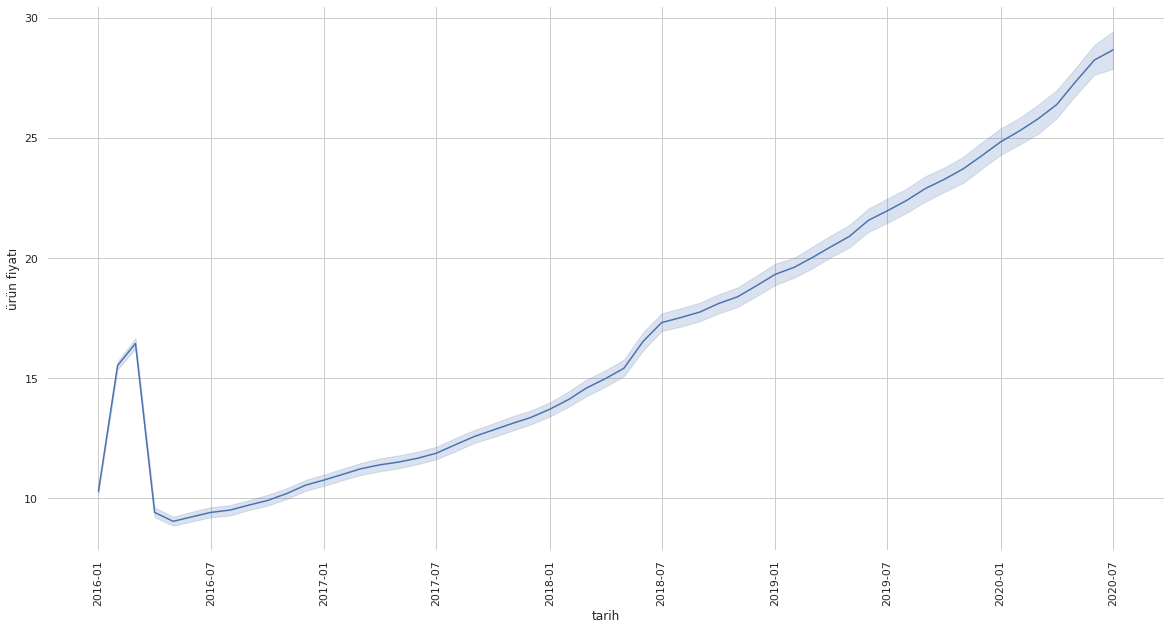

In [18]:
plt.figure(figsize=(20,10))
sbn.set_theme(style="whitegrid")
sbn.lineplot(x=train["tarih"],y=train["ürün fiyatı"]);
sbn.despine(bottom=True,left=True)
plt.xticks(rotation=90);

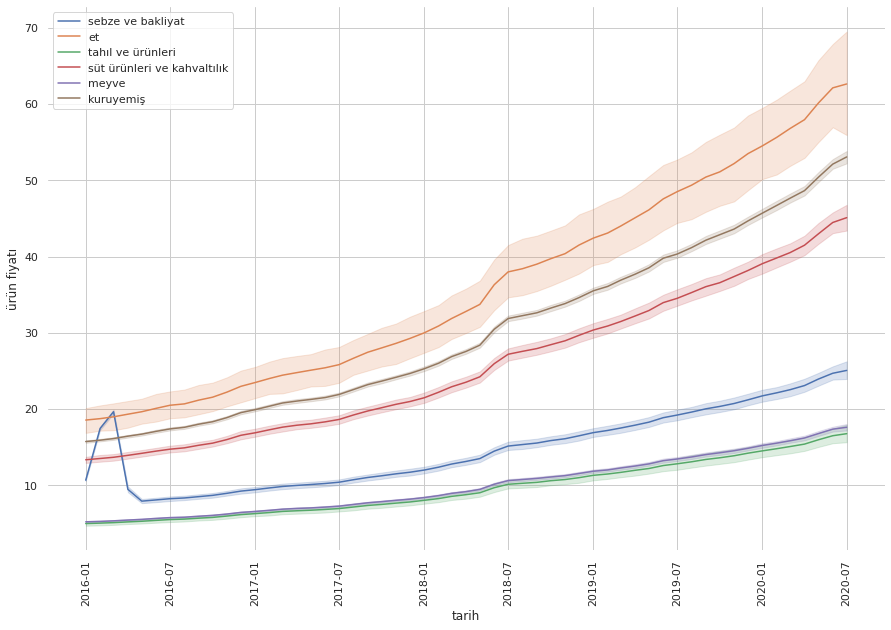

In [19]:
plt.figure(figsize=(15,10))
sbn.set_theme(style="whitegrid")
sbn.lineplot(x=train["tarih"],y=train["ürün fiyatı"],hue=train["ürün kategorisi"]);
sbn.despine(bottom=True,left=True)
plt.xticks(rotation=90);
plt.legend(loc="best");

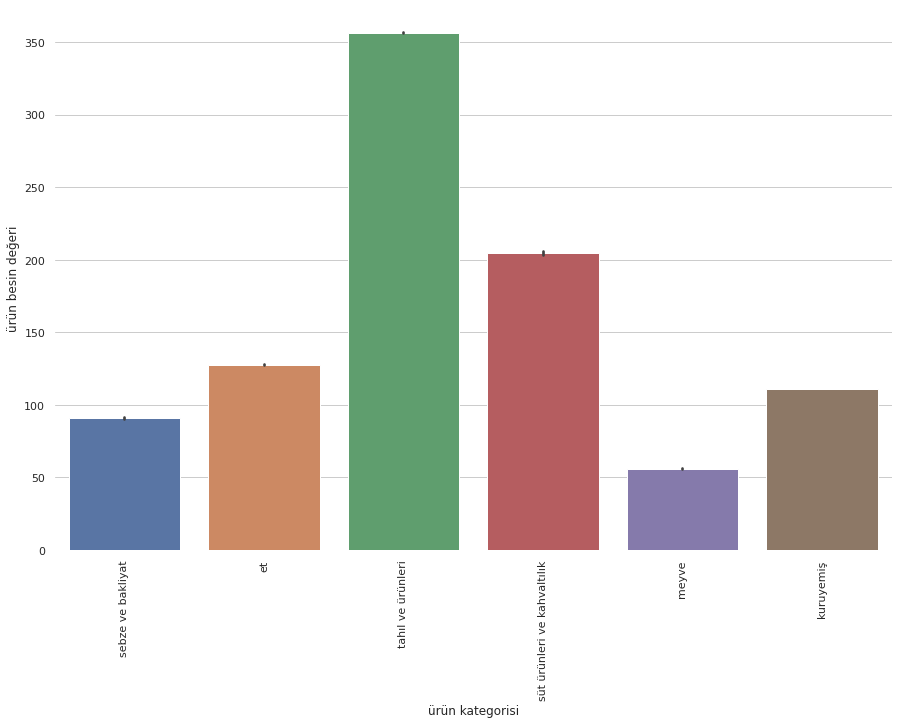

In [20]:
plt.figure(figsize=(15,10))
sbn.set_theme(style="whitegrid")
sbn.barplot(x=train["ürün kategorisi"],y=train["ürün besin değeri"]);
sbn.despine(bottom=True,left=True)
plt.xticks(rotation=90);

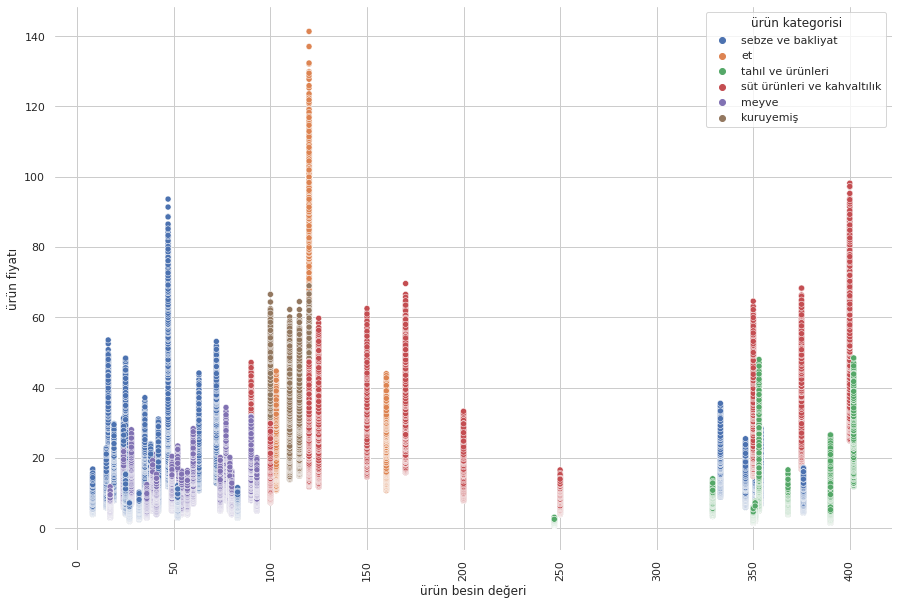

In [21]:
plt.figure(figsize=(15,10))
sbn.set_theme(style="whitegrid")
sbn.scatterplot(x=train["ürün besin değeri"],y=train["ürün fiyatı"],hue=train["ürün kategorisi"]);
sbn.despine(bottom=True,left=True)
plt.xticks(rotation=90);

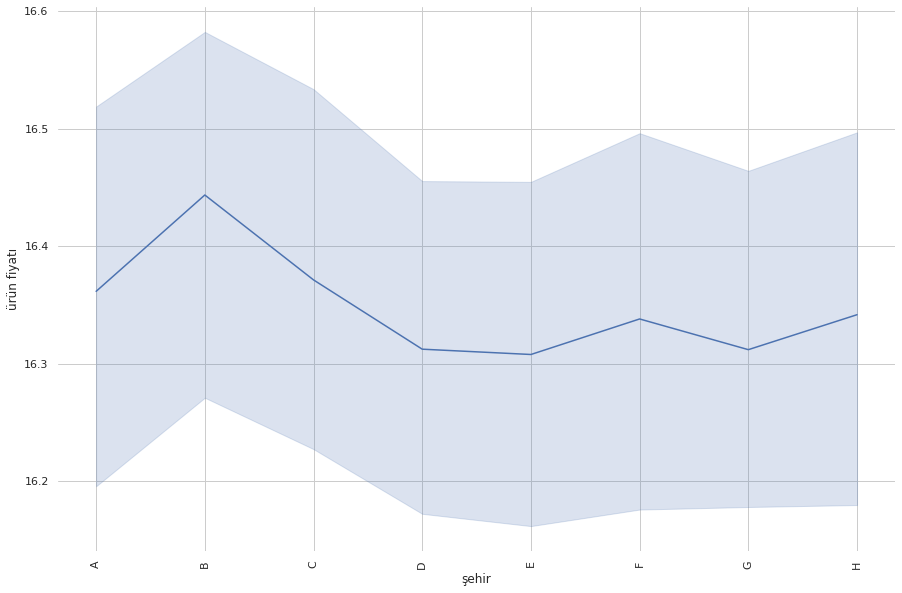

In [22]:
plt.figure(figsize=(15,10))
sbn.set_theme(style="whitegrid")
sbn.lineplot(x=train["şehir"],y=train["ürün fiyatı"]);
sbn.despine(bottom=True,left=True)
plt.xticks(rotation=90);

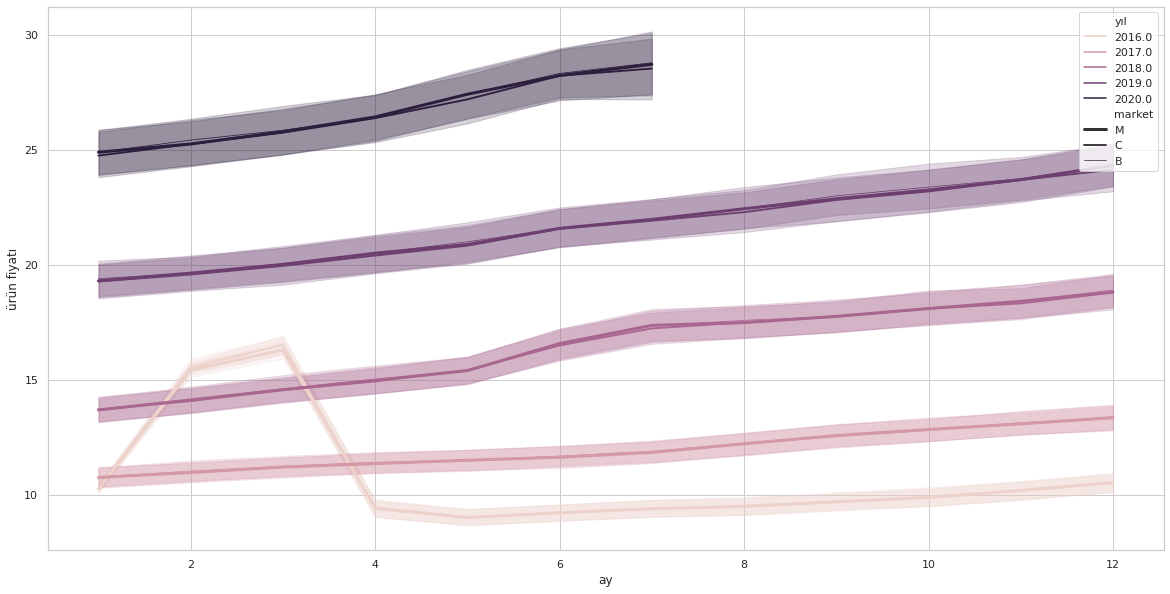

In [23]:
plt.figure(figsize=(20,10))
sbn.lineplot(x=train["ay"],y=train["ürün fiyatı"],hue=train["yıl"],size=train["market"]);
plt.legend(loc=1);

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


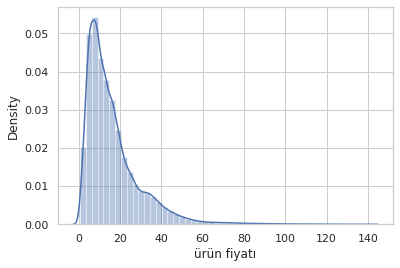

In [24]:
sbn.distplot(train["ürün fiyatı"]);

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


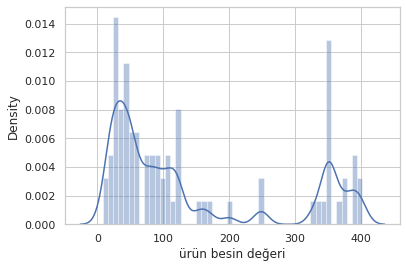

In [25]:
sbn.distplot(train["ürün besin değeri"]);

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


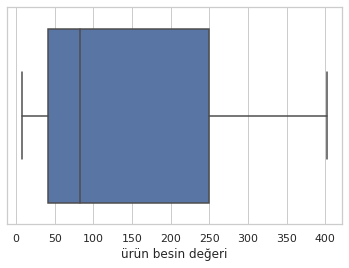

In [26]:
sbn.boxplot(train["ürün besin değeri"]);

In [27]:
train.corr().style.background_gradient()

,ürün besin değeri,ürün fiyatı,ürün üretim yeri,ürün durum,C,M,B,D,E,F,G,H,kuruyemiş,meyve,sebze ve bakliyat,süt ürünleri ve kahvaltılık,tahıl ve ürünleri,yıl,ay
ürün besin değeri,1.000000,0.017858,0.000000,0.272335,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.062661,-0.355444,-0.299696,0.195275,0.677353,-0.067192,-0.057968
ürün fiyatı,0.017858,1.000000,0.001386,-0.018194,0.000649,-0.000930,0.002708,-0.001031,-0.001160,-0.000298,-0.001043,-0.000195,0.268555,-0.260355,-0.082634,0.295875,-0.217408,0.381161,0.013049
ürün üretim yeri,0.000000,0.001386,1.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.002176
ürün durum,0.272335,-0.018194,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.076970,-0.160851,0.388812,-0.125316,-0.125316,-0.355910,-0.327865
C,0.000000,0.000649,0.000000,0.000000,1.000000,-0.000000,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.004193,0.004364
M,-0.000000,-0.000930,0.000000,-0.000000,-0.000000,1.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.001634,0.000753
B,0.000000,0.002708,-0.000000,0.000000,-0.142857,-0.000000,1.000000,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.006989,0.004981
D,0.000000,-0.001031,0.000000,0.000000,-0.142857,-0.000000,-0.142857,1.000000,-0.142857,-0.142857,-0.142857,-0.142857,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.001398,0.002033
E,0.000000,-0.001160,0.000000,0.000000,-0.142857,0.000000,-0.142857,-0.142857,1.000000,-0.142857,-0.142857,-0.142857,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.002796,-0.007014
F,0.000000,-0.000298,-0.000000,0.000000,-0.142857,0.000000,-0.142857,-0.142857,-0.142857,1.000000,-0.142857,-0.142857,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.005591,-0.009710


# Makine Öğrenimi ve gerekli Standardizasyon Aşaması

## MinMaxScaler ile M.Ö

In [28]:
x = train[["ürün besin değeri","ürün üretim yeri","ürün durum",'C', 'M', 'B', 'D',
       'E', 'F', 'G', 'H', 'kuruyemiş', 'meyve', 'sebze ve bakliyat',
       'süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri', 'yıl', 'ay']]
y = train["ürün fiyatı"]
mms = MinMaxScaler()
x_mms = mms.fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(x_mms,y,test_size=0.3,random_state=42)

In [29]:
x_train = pd.DataFrame(x_train,columns=["ürün besin değeri","ürün üretim yeri","ürün durum",'C', 'M', 'B', 'D',
       'E', 'F', 'G', 'H', 'kuruyemiş', 'meyve', 'sebze ve bakliyat',
       'süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri', 'yıl', 'ay'])

x_test = pd.DataFrame(x_test,columns=["ürün besin değeri","ürün üretim yeri","ürün durum",'C', 'M', 'B', 'D',
       'E', 'F', 'G', 'H', 'kuruyemiş', 'meyve', 'sebze ve bakliyat',
       'süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri', 'yıl', 'ay'])

In [30]:
xmms_sm = sm.add_constant(x_mms)
sm_model = sm.OLS(y,xmms_sm).fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ürün fiyatı   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.185e+04
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:01:19   Log-Likelihood:            -8.3570e+05
No. Observations:              227520   AIC:                         1.671e+06
Df Residuals:                  227501   BIC:                         1.672e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.4302      0.131    202.450      0.000      26.174      26.686
x1             1.7997      0.120     14.937      0.000       1.564       2.036
x2             0.0405      0.040      1.013      0.311      -0.038       0.119
x3             9.4728      0.132     71.606      0.000       9.213       9.732
x4            -0.0727      0.080     -0.909      0.363      -0.229       0.084
x5            -0.0075      0.042     -0.177      0.860      -0.091       0.076
x6             0.0409      0.080      0.512      0.608      -0.116       0.198
x7            -0.1691      0.080     -2.116      0.034      -0.326      -0.012
x8            -0.2173      0.080     -2.719      0.007      -0.374      -0.061
x9            -0.2237      0.080     -2.799      0.005      -0.380      -0.067
x10           -0.2805      0.080     -3.510      0.000      -0.437      -0.124
x11           -0.2750      0.080     -3.442      0.001      -0.432      -0.118
x12           -5.6007      0.130    -43.165      0.000      -5.855      -5.346
x13          -25.4055      0.113   -225.098      0.000     -25.627     -25.184
x14          -20.3497      0.112   -181.359      0.000     -20.570     -20.130
x15          -10.4563      0.117    -89.381      0.000     -10.686     -10.227
x16          -27.2327      0.134   -202.858      0.000     -27.496     -26.970
x17           16.8730      0.063    267.141      0.000      16.749      16.997
x18            2.6843      0.067     39.821      0.000       2.552       2.816
==============================================================================
Omnibus:                    88937.854   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           597524.675
Skew:                           1.737   Prob(JB):                         0.00
Kurtosis:                      10.139   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
abr = AdaBoostRegressor().fit(x_train,y_train)
#bgr = BaggingRegressor().fit(x_train,y_train)
gbr = GradientBoostingRegressor().fit(x_train,y_train)
rfr = RandomForestRegressor().fit(x_train,y_train)
dtr = DecisionTreeRegressor().fit(x_train,y_train)
eln = ElasticNet().fit(x_train,y_train)
xgb = XGBRegressor().fit(x_train,y_train)

rfe_abr = RFE(abr).fit(x_train,y_train)
#rfe_bgr = RFE(bgr).fit(x_train,y_train)
rfe_gbr = RFE(gbr).fit(x_train,y_train)
rfe_rfr = RFE(rfr).fit(x_train,y_train)
rfe_dtr = RFE(dtr).fit(x_train,y_train)
rfe_eln = RFE(eln).fit(x_train,y_train)
rfe_xgb = RFE(xgb).fit(x_train,y_train)

In [32]:
for i in [rfe_abr,rfe_gbr,rfe_rfr,rfe_dtr,rfe_eln,rfe_xgb]:
    print("{0}: ".format(i),list(zip(x_train.columns,i.support_,i.ranking_)))

RFE(estimator=AdaBoostRegressor()):  [('ürün besin değeri', True, 1), ('ürün üretim yeri', False, 2), ('ürün durum', False, 5), ('C', False, 10), ('M', True, 1), ('B', True, 1), ('D', False, 3), ('E', False, 8), ('F', False, 4), ('G', False, 9), ('H', False, 7), ('kuruyemiş', True, 1), ('meyve', True, 1), ('sebze ve bakliyat', False, 6), ('süt ürünleri ve kahvaltılık', True, 1), ('tahıl ve ürünleri', True, 1), ('yıl', True, 1), ('ay', True, 1)]
RFE(estimator=GradientBoostingRegressor()):  [('ürün besin değeri', True, 1), ('ürün üretim yeri', False, 8), ('ürün durum', True, 1), ('C', False, 7), ('M', False, 6), ('B', False, 5), ('D', False, 4), ('E', False, 2), ('F', False, 10), ('G', False, 9), ('H', False, 3), ('kuruyemiş', True, 1), ('meyve', True, 1), ('sebze ve bakliyat', True, 1), ('süt ürünleri ve kahvaltılık', True, 1), ('tahıl ve ürünleri', True, 1), ('yıl', True, 1), ('ay', True, 1)]
RFE(estimator=RandomForestRegressor()):  [('ürün besin değeri', True, 1), ('ürün üretim yeri',

In [33]:
x=x[["ürün besin değeri","ürün durum","kuruyemiş","meyve","sebze ve bakliyat","süt ürünleri ve kahvaltılık","tahıl ve ürünleri","yıl","ay"]]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [36]:
rfr = RandomForestRegressor().fit(x_train,y_train)
rfr_pred = rfr.predict(x_test)
mean_squared_error(rfr_pred,y_test)

7.418766478209768

In [38]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [40]:
import joblib
joblib.dump(rfr, "rfr.pkl")

['rfr.pkl']

In [42]:
test = test[["ürün besin değeri","ürün durum","kuruyemiş","meyve","sebze ve bakliyat","süt ürünleri ve kahvaltılık","tahıl ve ürünleri","yıl","ay"]]
test.head(2)

,ürün besin değeri,ürün durum,kuruyemiş,meyve,sebze ve bakliyat,süt ürünleri ve kahvaltılık,tahıl ve ürünleri,yıl,ay
11520,354,1,0,0,1,0,0,2016.0,4.0
11521,346,1,0,0,1,0,0,2016.0,4.0


In [43]:
rfr2 = joblib.load("rfr.pkl")
sonuç = rfr2.predict(test)
sonuç = pd.DataFrame([test.index,sonuç])
sonuç.to_csv("sonuç.csv")

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [44]:
test.isnull().sum

ürün besin değeri                  0
ürün durum                         0
kuruyemiş                          0
meyve                              0
sebze ve bakliyat                  0
süt ürünleri ve kahvaltılık        0
tahıl ve ürünleri                  0
yıl                            21312
ay                             21312
dtype: int64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1aac6121-63ff-4e03-bee2-c9e9831cab6d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>